In [1]:
import numpy as np
import glob
import torch
import matplotlib.pyplot as plt
import monai
from monai.visualize import matshow3d
import monai.transforms as mt
from monai.config import print_config
from monai.networks.nets import SegResNet
from monai.inferers import SlidingWindowInferer
from monai.metrics import DiceMetric

print_config()

Failed to load image Python extension: '/usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?


MONAI version: 1.2.0rc5+4.g4f291723
Numpy version: 1.22.2
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4f291723c4ce1a1baf7efbd499495b777dfb1869
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.3.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
def plot_img_operations(pair, every_n=10, keys=["image", "label"]):
    if isinstance(pair, list):
        print(f"metadata of patch idx 0 out of {len(pair)} samples.\n")
        p_0 = pair[0]
    else:
        p_0 = pair
    print("\n")
    p_0 = p_0["image"]
    if len(p_0.shape) > 4:
        p_0 = monai.utils.first(p_0)
    print(f"pixdim: {p_0.pixdim}")
    print(f"shape: {p_0.shape}")
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    matshow3d(pair[keys[0]], every_n=every_n, fig=plt.gca())
    plt.subplot(1, 2, 2)
    print(pair["image"].shape, pair["label"].shape)
    matshow3d(pair[keys[1]], every_n=every_n, fig=plt.gca())
    plt.show()
img_names = list(glob.glob("./totalSegmentator_mergedLabel_samples/imagesTr/*.nii.gz"))
seg_names = list(glob.glob("./totalSegmentator_mergedLabel_samples/labelsTr/*.nii.gz"))
datalist = [{"image": _img_name, "label": _seg_name} for _img_name, _seg_name in zip(img_names, seg_names)]

In [3]:
monai.utils.set_determinism(24)
both_keys = ["image", "label"]
transform_list_lazy = [
        mt.LoadImaged(keys=both_keys, image_only=True, ensure_channel_first=True),
        mt.EnsureTyped(keys=both_keys),
        mt.Orientationd(keys=both_keys, axcodes="RAS"),
        mt.Spacingd(keys=both_keys, pixdim=(3.0, 3.0, 3.0), mode=["bilinear", "nearest"]),
        # mt.Identityd(keys=["image"]),
        # mt.NormalizeIntensityd(keys=["image"], nonzero=True),
        # mt.CropForegroundd(keys=both_keys, source_key="image", margin=10, k_divisible=[96, 96, 96]),
        # mt.GaussianSmoothd(keys=["image"], sigma=0.4),
        # mt.ScaleIntensityd(keys=["image"], minv=-1.0, maxv=1.0),
]


xform = mt.Compose(
    transform_list_lazy, lazy_evaluation=False, override_keys=("image", "label"), overrides={"mode": ("bilinear", "nearest"), 'padding_mode': ('border', 'zeros'), 'dtype': torch.float32}
)
xform_inverse = mt.Compose(
    transform_list_lazy, lazy_evaluation=False, override_keys=("image", "label"), overrides={"mode": ("bilinear", "nearest"), 'padding_mode': ('border', 'zeros'), 'dtype': torch.float32}
)

def net_identity(data):
    return mt.AsDiscrete(to_onehot=105)(data.squeeze(0)).unsqueeze(0)

infer = SlidingWindowInferer(roi_size=[96, 96, 96], sw_batch_size=1, overlap=0.25)

data = datalist[1:2]


In [4]:
post_trans_v1 = mt.Compose([
    mt.Invertd(keys=["pred"], transform=xform_inverse, orig_keys="image", nearest_interp=False, to_tensor=True),
    mt.Invertd(keys=["label"], transform=xform_inverse, orig_keys="image", nearest_interp=True, to_tensor=True),
    mt.AsDiscreted(keys="pred", argmax=True),
])
out_v1 = xform(data)
print('After pre-processing:', out_v1[0]["label"].shape)

out_v1[0]["pred"] = infer(out_v1[0]["label"].unsqueeze(0), network=net_identity).squeeze(0)
print('After infer:', out_v1[0]["pred"].shape, np.unique(out_v1[0]["pred"]))
out_v1_post = post_trans_v1(out_v1[0])
print("After inverse:", out_v1_post["pred"].shape, out_v1_post["label"].shape)

After pre-processing: torch.Size([1, 130, 130, 142])
After infer: torch.Size([105, 130, 130, 142]) [0. 1.]
After inverse: torch.Size([1, 259, 259, 283]) torch.Size([1, 259, 259, 283])


In [5]:
post_trans_v2 = mt.Compose([
    mt.AsDiscreted(keys="pred", argmax=True),
    mt.Invertd(keys=["pred", "label"], transform=xform_inverse, orig_keys="image", nearest_interp=True, to_tensor=True),
])

out_v2 = xform(data)
print('After pre-processing:', out_v2[0]["label"].shape)
def net_identity(data):
    return mt.AsDiscrete(to_onehot=105)(data.squeeze(0)).unsqueeze(0)

infer = SlidingWindowInferer(roi_size=[96, 96, 96], sw_batch_size=1, overlap=0.25)
out_v2[0]["pred"] = infer(out_v2[0]["label"].unsqueeze(0), network=net_identity).squeeze(0)
print('After infer:', out_v2[0]["pred"].shape)
out_v2_post = post_trans_v2(out_v2[0])
print("After inverse:", out_v2_post["pred"].shape)

After pre-processing: torch.Size([1, 130, 130, 142])
After infer: torch.Size([105, 130, 130, 142])
After inverse: torch.Size([1, 259, 259, 283])


In [6]:
data_raw = mt.LoadImaged(keys=both_keys, image_only=True, ensure_channel_first=True)(data[0])

In [7]:
metric = DiceMetric(include_background=False, num_classes=105)
metric(out_v1_post["pred"].unsqueeze(0), out_v2_post["pred"].unsqueeze(0))
_metric = metric.aggregate().item()
metric.reset()
print(_metric)

0.8740721344947815


In [8]:
metric = DiceMetric(include_background=False, num_classes=105)
metric(out_v1_post["pred"].unsqueeze(0), data_raw["label"].unsqueeze(0))
_metric = metric.aggregate().item()
metric.reset()
print(_metric)

0.903397798538208


In [9]:
metric = DiceMetric(include_background=False, num_classes=105)
metric(out_v2_post["pred"].unsqueeze(0), data_raw["label"].unsqueeze(0))
_metric = metric.aggregate().item()
metric.reset()
print(_metric)

0.8830903172492981


(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

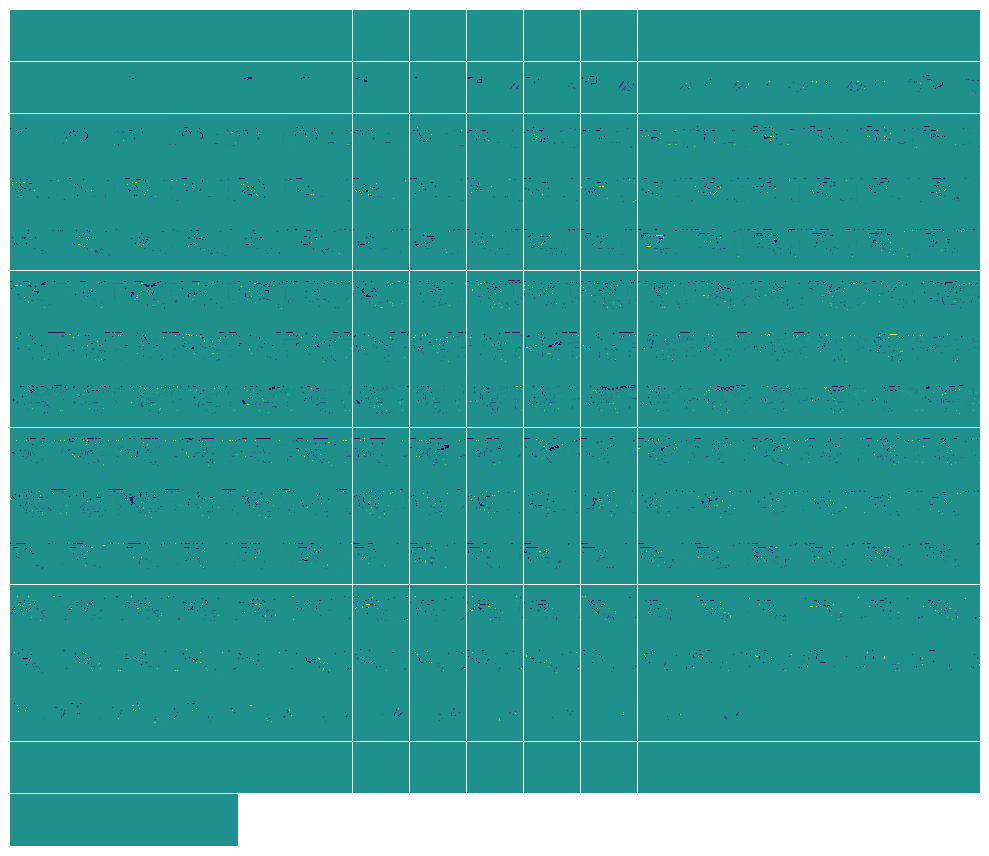

In [13]:
diff_v1v2 = out_v1_post["pred"] - out_v2_post["pred"]
matshow3d(diff_v1v2, every_n=1)

(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

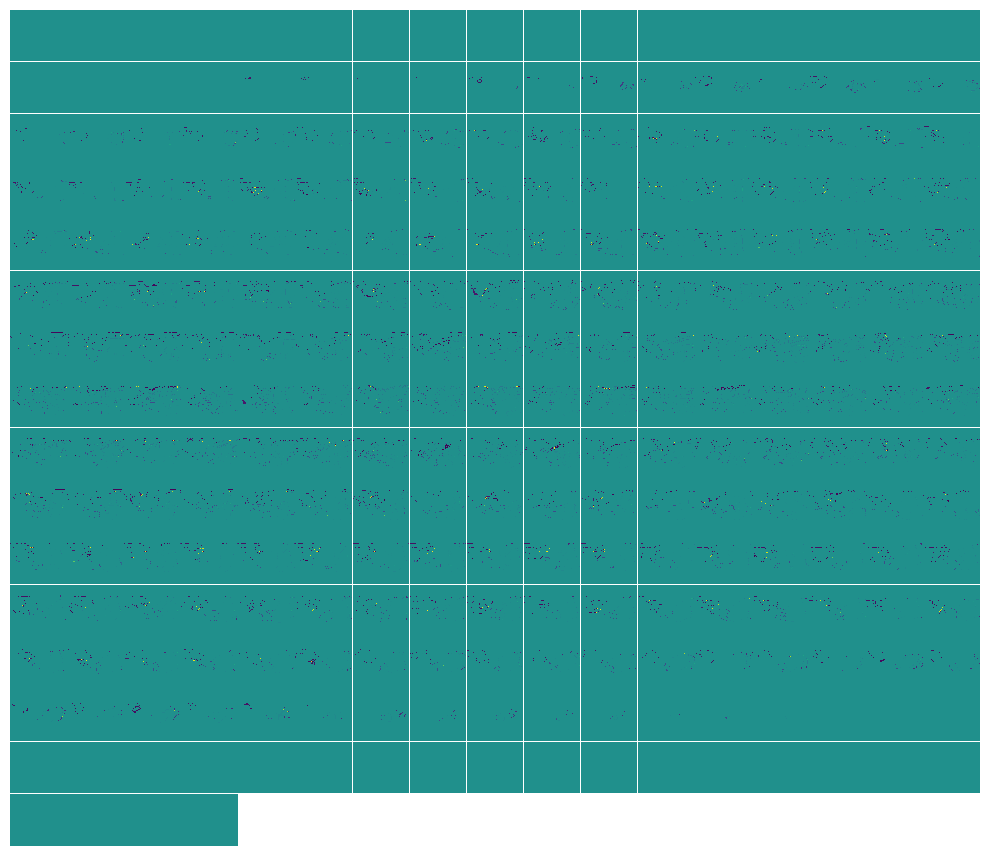

In [15]:
matshow3d((out_v1_post["pred"] - data_raw["label"]), every_n=1)